In [111]:
# Notes for user:
# This notebook will use the US gasoline price API dataset and forex to predict the forex spot price of a currency pair.
# What to ask user before using this application:
# What currency pair are you interested in? USD/GBP (This layout means that the base currency is USD)
# The currency the user wants to look at is how much the USD is worth to the GBP.
# Therefore, we look at the price of gasoline of the US and the UK.
# So far all that is inputted is the forex price so we can understand the model
# We will need to organise US gasoline price dataset.

In [112]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-9nmo059n
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-9nmo059n
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.028e526366a3d3620adc3c375287ab71cf412bac8_-cp36-none-any.whl size=124955 sha256=43c2cbfa36c1c3bc8e927ca637ac413a5042e102ca5a56beaf5481fbab7dea33
  Stored in directory: /tmp/pip-ephem-wheel-cache-8is1vpi4/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [113]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
# modelling
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

#modeling metrics
from sklearn import metrics

2.2.0


# Data Collection

In [114]:
# Import forex
# Need to get the most recent dataset
forex_dataset_data= pd.read_csv('GBP_USD.csv', na_values = "?", comment='\t', skipinitialspace=True)
forex_dataset = forex_dataset_data.copy()
# forex_dataset = forex_dataset_data.dropna()
# Filter dataset


In [115]:
forex_dataset.shape

(155, 6)

In [116]:
forex_dataset.head() 
# head => starting from bottom
# tail => starting from top

,Date,Price,Open,High,Low,Change %
0,"Jul 03, 2020",1.2482,1.2466,1.2493,1.2439,0.12%
1,"Jul 02, 2020",1.2467,1.2476,1.2531,1.2456,-0.05%
2,"Jul 01, 2020",1.2474,1.2401,1.2492,1.2358,0.59%
3,"Jun 30, 2020",1.2401,1.2298,1.2402,1.2257,0.83%
4,"Jun 29, 2020",1.2299,1.2340,1.2391,1.2251,-0.30%


In [117]:
!pip install EIA_python

In [118]:
import eia
import pandas as pd

def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    data = series_search['U.S. All Grades All Formulations Retail Gasoline Prices, Weekly (Dollars per Gallon)']
    us_fuel_dataset = pd.DataFrame(list(data.items()), columns=["date", "price"])
    return us_fuel_dataset

def get_us_fuel_dataset():
    #Create EIA API using your specific API key
    api_key = "a02f4b9f170de93fa421d806a4fdd23c"
    api = eia.API(api_key)
    #Declare desired series ID
    series_ID='PET.EMM_EPM0_PTE_NUS_DPG.W'
    us_fuel_dataset=retrieve_time_series(api, series_ID)
    return us_fuel_dataset

In [119]:
us_fuel_dataset.head() 

,price,date,week
date,,,
2020-07-20,2.275,2020-07-20,2020-07-20/2020-07-26
2020-07-13,2.283,2020-07-13,2020-07-13/2020-07-19
2020-07-06,2.265,2020-07-06,2020-07-06/2020-07-12
2020-06-29,2.260,2020-06-29,2020-06-29/2020-07-05
2020-06-22,2.216,2020-06-22,2020-06-22/2020-06-28


In [120]:
us_fuel_dataset = get_us_fuel_dataset()
us_fuel_dataset.shape

(1425, 2)

In [121]:
us_fuel_dataset.head()

,date,price
0,2020 0720 20,2.275
1,2020 0713 13,2.283
2,2020 0706 06,2.265
3,2020 0629 29,2.260
4,2020 0622 22,2.216


# Data Preprocessing / Data Cleaning & Collating

In [122]:
# Create Time series and price columns
# First convert string type to datetime type for pandas series "date"
# Then convert price to numeric type
us_fuel_dataset['date'] = us_fuel_dataset['date'].apply(lambda x: pd.to_datetime(str(x.strip().replace(" ", "")[0:8]), format='%Y%m%d'))
us_fuel_dataset['price'] = pd.to_numeric(us_fuel_dataset['price'])
forex_dataset["Date"] = pd.to_datetime(forex_dataset["Date"])

In [123]:
# Our columns are converted correctly
us_fuel_dataset.dtypes


date     datetime64[ns]
price           float64
dtype: object

In [124]:
forex_dataset.dtypes

Date        datetime64[ns]
Price              float64
Open               float64
High               float64
Low                float64
Change %            object
dtype: object

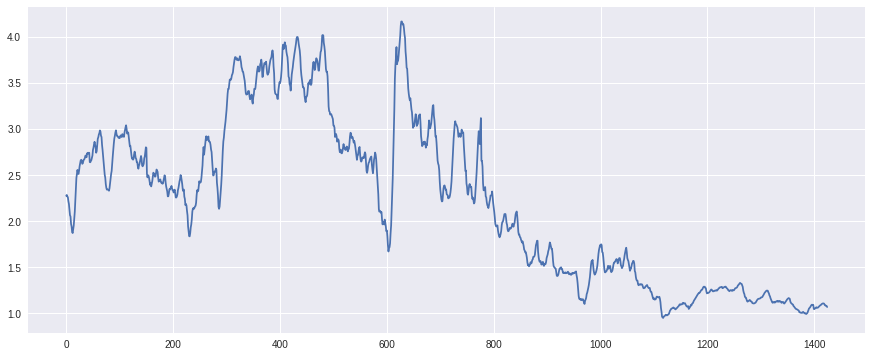

In [125]:
us_fuel_dataset["price"].plot()

In [126]:
forex_dataset.set_index("Date", inplace=True)
us_fuel_dataset.set_index("date", inplace=True)
forex_dataset["date"] = forex_dataset.index
us_fuel_dataset["date"] = us_fuel_dataset.index

In [127]:
us_fuel_dataset["week"] = us_fuel_dataset.index.to_period('W')
forex_dataset["week"] = forex_dataset.index.to_period('W')

In [128]:
forex_dataset.head(15)

,Price,Open,High,Low,Change %,date,week
Date,,,,,,,
2020-07-03,1.2482,1.2466,1.2493,1.2439,0.12%,2020-07-03,2020-06-29/2020-07-05
2020-07-02,1.2467,1.2476,1.2531,1.2456,-0.05%,2020-07-02,2020-06-29/2020-07-05
2020-07-01,1.2474,1.2401,1.2492,1.2358,0.59%,2020-07-01,2020-06-29/2020-07-05
2020-06-30,1.2401,1.2298,1.2402,1.2257,0.83%,2020-06-30,2020-06-29/2020-07-05
2020-06-29,1.2299,1.2340,1.2391,1.2251,-0.30%,2020-06-29,2020-06-29/2020-07-05
2020-06-26,1.2335,1.2421,1.2438,1.2313,-0.66%,2020-06-26,2020-06-22/2020-06-28
2020-06-25,1.2418,1.2419,1.2465,1.2388,-0.02%,2020-06-25,2020-06-22/2020-06-28
2020-06-24,1.2420,1.2521,1.2543,1.2414,-0.79%,2020-06-24,2020-06-22/2020-06-28
2020-06-23,1.2520,1.2467,1.2533,1.2431,0.45%,2020-06-23,2020-06-22/2020-06-28


In [129]:
dataset = pd.merge(
    forex_dataset,
    us_fuel_dataset,
    left_on="week",
    right_on="week",
    how="left"
)

In [130]:
dataset.head(10)

,Price,Open,High,Low,Change %,date_x,week,price,date_y
0,1.2482,1.2466,1.2493,1.2439,0.12%,2020-07-03,2020-06-29/2020-07-05,2.260,2020-06-29
1,1.2467,1.2476,1.2531,1.2456,-0.05%,2020-07-02,2020-06-29/2020-07-05,2.260,2020-06-29
2,1.2474,1.2401,1.2492,1.2358,0.59%,2020-07-01,2020-06-29/2020-07-05,2.260,2020-06-29
3,1.2401,1.2298,1.2402,1.2257,0.83%,2020-06-30,2020-06-29/2020-07-05,2.260,2020-06-29
4,1.2299,1.2340,1.2391,1.2251,-0.30%,2020-06-29,2020-06-29/2020-07-05,2.260,2020-06-29
5,1.2335,1.2421,1.2438,1.2313,-0.66%,2020-06-26,2020-06-22/2020-06-28,2.216,2020-06-22
6,1.2418,1.2419,1.2465,1.2388,-0.02%,2020-06-25,2020-06-22/2020-06-28,2.216,2020-06-22
7,1.2420,1.2521,1.2543,1.2414,-0.79%,2020-06-24,2020-06-22/2020-06-28,2.216,2020-06-22
8,1.2520,1.2467,1.2533,1.2431,0.45%,2020-06-23,2020-06-22/2020-06-28,2.216,2020-06-22
9,1.2463,1.2356,1.2478,1.2335,0.85%,2020-06-22,2020-06-22/2020-06-28,2.216,2020-06-22


# Sample Features - Go Over


In [131]:
# Look back last 4 days
# X variables/ features that we care about
# Y variable/ output/ what we want to predict
window_size=12
num_samples=len(dataset)-window_size

# Get indices of access for the data
indices=np.arange(num_samples).astype(np.int)[:,None]+np.arange(window_size+1).astype(np.int)

data = dataset["Price"].values[indices] # Create the 2D matrix of training samples
x = data[:,:-1] # Each row represents 12 days in the past
y = data[:,-1] # Each output value represents the 13rd day

In [132]:
# not data frame anymore now it is a list
# forex_dataset.head() of it
x

array([[1.2482, 1.2467, 1.2474, ..., 1.2463, 1.2358, 1.2426],
       [1.2467, 1.2474, 1.2401, ..., 1.2358, 1.2426, 1.2557],
       [1.2474, 1.2401, 1.2299, ..., 1.2426, 1.2557, 1.2577],
       ...,
       [1.3004, 1.3009, 1.3078, ..., 1.3145, 1.3137, 1.3157],
       [1.3009, 1.3078, 1.313 , ..., 1.3137, 1.3157, 1.3104],
       [1.3078, 1.313 , 1.3331, ..., 1.3157, 1.3104, 1.2994]])

In [133]:
y

array([1.2557, 1.2577, 1.2604, 1.2542, 1.2602, 1.2747, 1.2731, 1.2723,
       1.2665, 1.2595, 1.2574, 1.255 , 1.2494, 1.2346, 1.232 , 1.2252,
       1.2333, 1.219 , 1.2166, 1.2224, 1.2241, 1.2253, 1.2193, 1.2106,
       1.2228, 1.223 , 1.2261, 1.2336, 1.2409, 1.2363, 1.2343, 1.2436,
       1.2444, 1.2504, 1.2594, 1.2468, 1.2425, 1.2429, 1.2369, 1.2344,
       1.2334, 1.2294, 1.2437, 1.2501, 1.2457, 1.2516, 1.2624, 1.2512,
       1.2455, 1.2457, 1.2387, 1.2339, 1.223 , 1.2262, 1.2394, 1.2378,
       1.242 , 1.2418, 1.2457, 1.2203, 1.1887, 1.1759, 1.155 , 1.1643,
       1.1487, 1.1608, 1.2052, 1.2268, 1.2277, 1.2573, 1.2822, 1.2908,
       1.3133, 1.305 , 1.2955, 1.2872, 1.2812, 1.2752, 1.2821, 1.2886,
       1.2905, 1.3006, 1.2929, 1.2971, 1.2881, 1.2921, 1.2999, 1.3009,
       1.3047, 1.3047, 1.2961, 1.2953, 1.2915, 1.2893, 1.293 , 1.3002,
       1.3031, 1.2995, 1.3201, 1.3095, 1.3021, 1.3028, 1.3055, 1.3077,
       1.3123, 1.3142, 1.3051, 1.3011, 1.301 , 1.3079, 1.3038, 1.3018,
      

In [134]:
# 80% of my data
split_fraction=0.8
ind_split=int(split_fraction*num_samples)

In [135]:
# x features and y features
# test and train
x_train = x[:ind_split]
y_train = y[:ind_split]
x_test = x[ind_split:]
y_test = y[ind_split:]

In [136]:
x_train.shape, x_test.shape

((114, 12), (29, 12))

In [137]:
y_train.shape, y_test.shape

((114,), (29,))

# Modelling

In [138]:
# Help Functions
# Need to consider the trade offs between the models you use
def get_performance (model_pred):
  #Function returns standard performance metrics
  print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, model_pred).round(4))  
  print('Mean Squared Error:', metrics.mean_squared_error(y_test, model_pred).round(4))  
  print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, model_pred)).round(4))
  
  
  
def get_plot (model_pred):
  plt.scatter(model_pred, y_test, color="gray")
  plt.plot(y_test, y_test, color='red', linewidth=2)

# Baseline

In [139]:
# let your prediction be the most recent observation
# looking at the one day previous 
# np.roll-> similar to shift for a dataframe
y_pred_lag=np.roll(y_test,1)

In [140]:
# np.roll(y,1)

In [141]:
# any has to be better than this
# performance reltive to that very simlpe approach
get_performance(y_pred_lag)

Mean Absolute Error: 0.0059
Mean Squared Error: 0.0001
Root Mean Squared Error: 0.0077


Text(0, 0.5, 'Price of USD/GBP & Gas Prices')

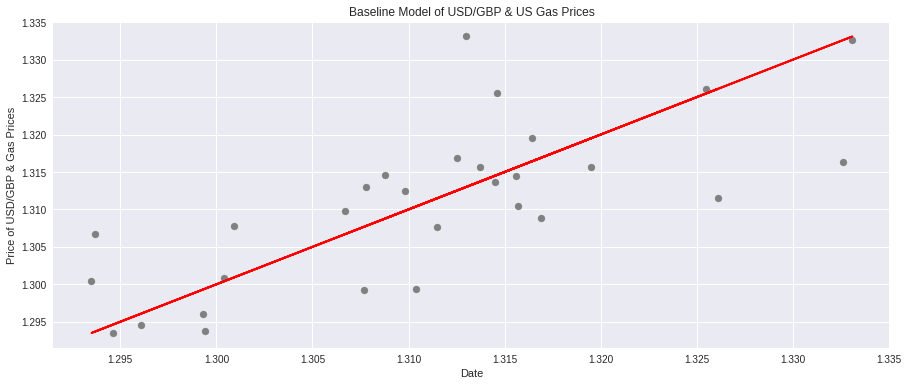

In [142]:
# Why cant I print dates on the bottom of my graph?
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
plt.style.use('seaborn')
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,6

get_plot(y_pred_lag)
# plt.plot(y_pred_gb)
plt.title('Baseline Model of USD/GBP & US Gas Prices')
plt.xlabel('Date')
plt.ylabel('Price of USD/GBP & Gas Prices')
# dates = np.array(dateFormatting['Date'])
# plt.plot_date(dates,y_pred_gb, linestyle ='solid')

# Linear Regression

In [143]:
# assigning the linear regression model
model_lr=LinearRegression()
# fitting the linear regression model to xtrain, xytrain
model_lr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [144]:
#help
# ?model_lr.fit()

In [145]:
# x variable and predict the y 
y_pred_lr=model_lr.predict(x_test)

In [146]:
# check how they compare to the baseline
# not a big difference at all only in root mean
# not great
get_performance(y_pred_lr)

Mean Absolute Error: 0.0061
Mean Squared Error: 0.0001
Root Mean Squared Error: 0.0076


Text(0, 0.5, 'Price')

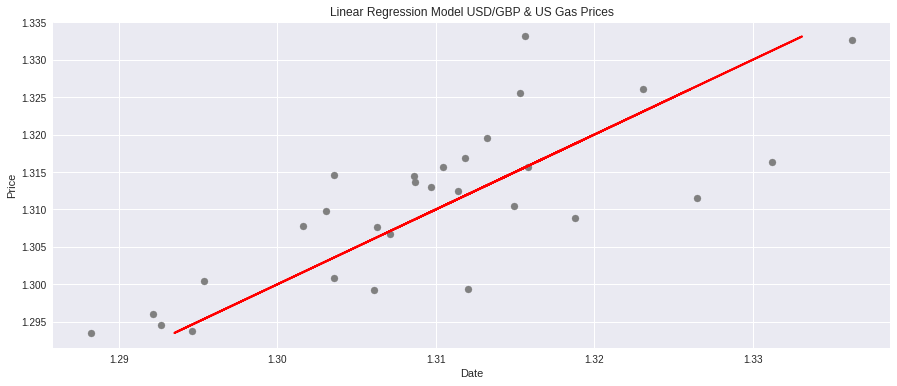

In [147]:
# Why cant I print dates on the bottom of my graph?
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
plt.style.use('seaborn')
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,6

get_plot(y_pred_lr)
# plt.plot(y_pred_gb)
plt.title('Linear Regression Model USD/GBP & US Gas Prices')
plt.xlabel('Date')
plt.ylabel('Price')
# dates = np.array(dateFormatting['Date'])
# plt.plot_date(dates,y_pred_gb, linestyle ='solid')

In [148]:
get_performance(y_pred_lr)

Mean Absolute Error: 0.0061
Mean Squared Error: 0.0001
Root Mean Squared Error: 0.0076


In [149]:
# this should list our 12 co-efficients for all of our variables
# most recent day: 1.18024445
# as you can see other values are - and small, this is why the baseline 
# is so good because the previous day is the msot important value
# change is marginal
# only focus on the the last one
# problem: only print the last output
model_lr.coef_

array([-0.07226882,  0.21106539, -0.31282709,  0.25198096,  0.02830697,
        0.02865182, -0.11006445, -0.00665859, -0.23915759,  0.1989493 ,
       -0.25224128,  1.23650558])



```
# This is formatted as code
```

# Ridge Regression

In [150]:
model_ridge = Ridge()
model_ridge.fit(x_train, y_train)

#generate predictions
y_pred_ridge=model_ridge.predict(x_test)

In [151]:
# look at difference in baseline and ridge regression
# trying to figure out which one of the features is the most prominent
get_performance(y_pred_ridge)

Mean Absolute Error: 0.0252
Mean Squared Error: 0.0007
Root Mean Squared Error: 0.0273


Text(0, 0.5, 'Price')

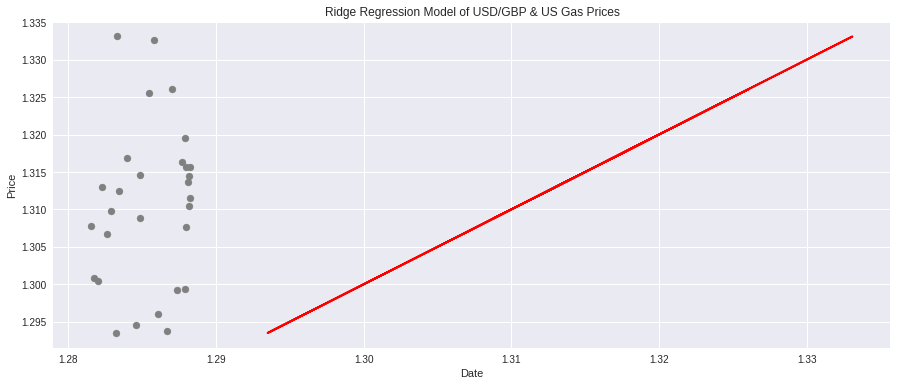

In [152]:
# Why cant I print dates on the bottom of my graph?
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
plt.style.use('seaborn')
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,6

get_plot(y_pred_ridge)
# plt.plot(y_pred_gb)
plt.title('Ridge Regression Model of USD/GBP & US Gas Prices')
plt.xlabel('Date')
plt.ylabel('Price')
# dates = np.array(dateFormatting['Date'])
# plt.plot_date(dates,y_pred_gb, linestyle ='solid')

In [153]:
# this should list our 12 co-efficients for all of our variables
# most recent day: 0.09432427
# change is marginal
# only focus on the the last one
# problem: only print the last output
# limit the number of days your looking back
# what is the trend: higher/lower?
# keep same features but apply different features
# k folds cross validation? in terms of splitting the data
model_ridge.coef_

array([0.02031357, 0.01914152, 0.01818677, 0.01932642, 0.02067214,
       0.0242695 , 0.03147673, 0.04169279, 0.0545068 , 0.06866123,
       0.08177461, 0.09457692])

# Gradient Boosting Trees

In [154]:
# Model #2 - Gradient Boosting Trees
# not linear, tree based
model_gb = GradientBoostingRegressor()
model_gb.fit(x_train, y_train)

# Infer
y_pred_gb = model_gb.predict(x_test)

In [155]:
get_performance(y_pred_gb)

Mean Absolute Error: 0.0083
Mean Squared Error: 0.0001
Root Mean Squared Error: 0.0107


Text(0, 0.5, 'Price')

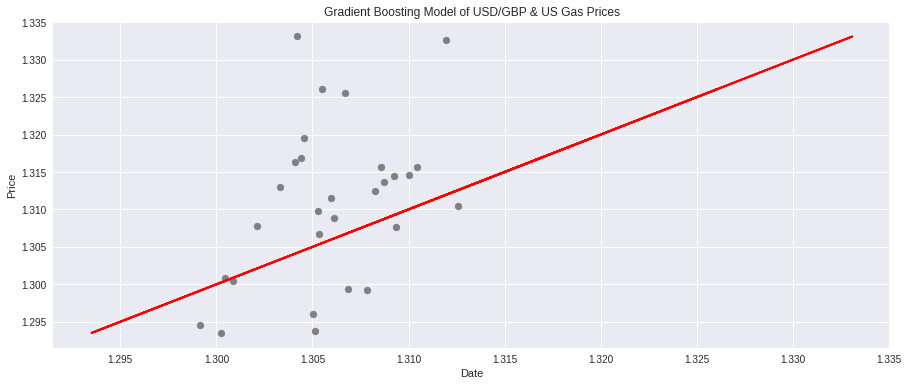

In [156]:
# Why cant I print dates on the bottom of my graph?
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
plt.style.use('seaborn')
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,6

get_plot(y_pred_gb)
# plt.plot(y_pred_gb)
plt.title('Gradient Boosting Model of USD/GBP & US Gas Prices')
plt.xlabel('Date')
plt.ylabel('Price')
# dates = np.array(dateFormatting['Date'])
# plt.plot_date(dates,y_pred_gb, linestyle ='solid')

# Comparison

In [157]:
# absolute -> only have positives
df_comp=pd.DataFrame({"lag":np.absolute(y_test-y_pred_lag), 
              "lr":np.absolute(y_test-y_pred_lr), 
              "ridge":np.absolute(y_test-y_pred_ridge),
              "gb":np.absolute(y_test-y_pred_gb)})

In [158]:
df_comp.head()

,lag,lr,ridge,gb
0,0.0130,0.000406,0.024095,0.001338
1,0.0031,0.006745,0.026907,0.004501
2,0.0027,0.001114,0.029090,0.004229
3,0.0044,0.005052,0.032899,0.012472
4,0.0081,0.009952,0.023972,0.002657


In [159]:
# go over again 51:22
y_pred_lag

array([1.2937, 1.3067, 1.3098, 1.3125, 1.3169, 1.3088, 1.3146, 1.3255,
       1.3261, 1.3115, 1.3077, 1.2993, 1.2961, 1.2946, 1.2935, 1.3004,
       1.3009, 1.3078, 1.313 , 1.3331, 1.3326, 1.3164, 1.3195, 1.3156,
       1.3145, 1.3137, 1.3157, 1.3104, 1.2994])

(11.0, 20.0)

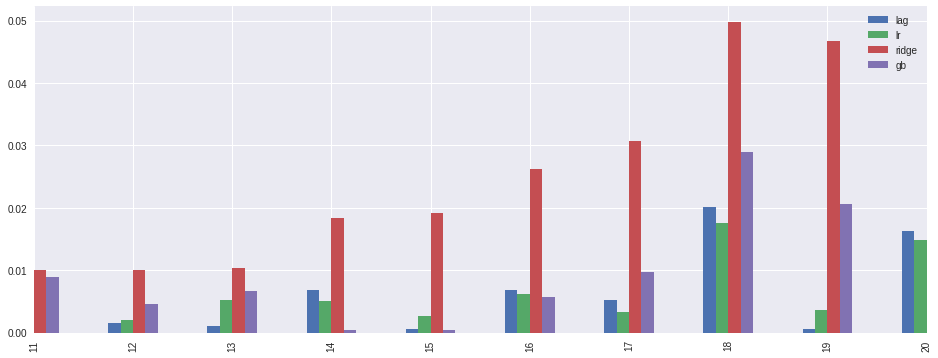

In [160]:
#
df_comp.plot.bar(figsize=(16, 6))
# show me days 0 to 10
plt.xlim(11,20)
# unsure why this line doesnt work
# plt.ylim(0,10)

# Conclusion and next steps

Explored 4 different algorithms, ranging from simple to complex:


*   Lag (Previous day's price)
*   Linear Regression 
*   Ridge Regression
*   Gradient Boosting Trees

In conclusion it seems that Linear Regression gives us the best performance with the least complexity. Next steps might include adding additional features such as trend and recent volatility (go over).


